# PWC Optimization

In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import qctrlvisualizer as qv
import qutip as qt
from scipy.optimize import minimize, OptimizeResult


@dataclass
class OptimizationResult:
    result: OptimizeResult
    times: npt.NDArray[np.float64]
    params: npt.NDArray[np.float64]
    pulse: npt.NDArray[np.complex128]

    def plot(self):
        pulse = np.append(self.pulse, self.pulse[-1])
        plt.step(self.times, np.real(pulse), where="post", label="I")
        plt.step(self.times, np.imag(pulse), where="post", label="Q")
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()


@dataclass
class SimulationResult:
    times: npt.NDArray[np.float64]
    unitaries: list[qt.Qobj]
    states: list[qt.Qobj]
    infidelities: list[float]

    @property
    def dimension(self) -> int:
        return self.states[0].shape[0]

    @property
    def populations(self) -> npt.NDArray:
        return np.abs(np.array(self.states).squeeze()) ** 2

    def display_bloch_sphere(self):
        states = np.array(self.states).squeeze()
        qv.display_bloch_sphere(states[:, :2])

    def plot_populations(self):
        qv.plot_population_dynamics(
            sample_times=self.times,
            populations={
                rf"$|{k}\rangle$": self.populations[:, k] for k in range(self.dimension)
            },
        )

    def print_final_populations(self):
        population = self.populations[-1]
        for k in range(self.dimension):
            print(f"|{k}> : {population[k]:>6.2%}")

    def plot_unitary_infidelities(self):
        plt.plot(self.times, self.infidelities)
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.ylim(0, 1)


class PulseOptimizer:
    def __init__(
        self,
        dimension: int,
        detuning: float,
        anharmonicity: float,
        segment_count: int,
        segment_width: float,
    ):
        self.dimension = dimension
        self.detuning = detuning
        self.anharmonicity = anharmonicity
        self.segment_count = segment_count
        self.segment_width = segment_width
        self.duration = segment_count * segment_width
        self.a = qt.destroy(self.dimension)
        self.ad = self.a.dag()
        self.H_sys = self.system_hamiltonian()

    def system_hamiltonian(self) -> qt.Qobj:
        omega = 2 * np.pi * self.detuning
        alpha = 2 * np.pi * self.anharmonicity
        a = self.a
        ad = self.ad
        H_sys = omega * ad * a + 0.5 * alpha * ad * ad * a * a
        return H_sys

    def pwc_unitary(self, value: complex, duration: float) -> qt.Qobj:
        H_ctrl = 0.5 * (self.ad * value + self.a * np.conj(value))
        H = self.H_sys + H_ctrl
        U = (-1j * H * duration).expm()
        return U

    def objective_function(self, params: npt.NDArray[np.float64]) -> float:
        pulse = self.params_to_pulse(params)
        U = qt.qeye(self.dimension)
        for value in pulse:
            U = self.pwc_unitary(value, self.segment_width) * U
        return self.unitary_infidelity(U, self.target_unitary)

    def unitary_infidelity(self, U1: qt.Qobj, U2: qt.Qobj) -> float:
        return 1 - np.abs((U1.dag() * U2).tr() / self.dimension) ** 2

    def random_params(self) -> npt.NDArray[np.float64]:
        return np.random.uniform(-1, 1, 2 * self.segment_count)

    def params_to_pulse(
        self,
        params: npt.NDArray[np.float64],
    ) -> npt.NDArray[np.complex128]:
        params = params.reshape((self.segment_count, 2))
        return params[:, 0] + 1j * params[:, 1]

    def optimize(
        self,
        initial_params: npt.NDArray[np.float64],
        target_unitary: qt.Qobj,
    ) -> OptimizationResult:
        self.target_unitary = target_unitary
        result = minimize(
            self.objective_function,
            initial_params,
            method="BFGS",
        )
        params = result.x
        pulse = self.params_to_pulse(params)
        times = np.linspace(0, self.duration, self.segment_count + 1)
        return OptimizationResult(
            result=result,
            times=times,
            params=params,
            pulse=pulse,
        )

    def simulate(
        self,
        pulse: npt.NDArray[np.complex128],
        steps_per_segment: int,
    ) -> SimulationResult:
        pulse = np.repeat(pulse, steps_per_segment)
        segment_count = self.segment_count * steps_per_segment
        times = np.linspace(0, self.duration, segment_count + 1)
        unitaries = [qt.qeye(self.dimension)]
        states = [qt.basis(self.dimension, 0)]
        infidelities = [0.0]
        segment_width = self.segment_width / steps_per_segment
        for value in pulse:
            U = self.pwc_unitary(value, segment_width) * unitaries[-1]
            unitaries.append(U)
            state = U * states[0]
            states.append(state)
            infidelity = self.unitary_infidelity(U, self.target_unitary)
            infidelities.append(infidelity)
        return SimulationResult(
            times=times,
            unitaries=unitaries,
            states=states,
            infidelities=infidelities,
        )

In [2]:
optimizer = PulseOptimizer(
    dimension=3,
    detuning=0.0,
    anharmonicity=-0.3,
    segment_count=10,
    segment_width=2.0,
)

In [3]:
initial_params = optimizer.random_params()
initial_params

array([-0.67831469,  0.66490962, -0.48696973, -0.48616883, -0.15942138,
       -0.22948272,  0.25108514,  0.38497901,  0.51568222, -0.87314397,
       -0.36740162,  0.84438947, -0.7561274 ,  0.14224703,  0.17582941,
       -0.74479871, -0.85517755, -0.66090944, -0.88785172,  0.79886523])

In [4]:
w = np.exp(1j * 2 * np.pi / 3)

target_unitary = qt.Qobj(
    [
        [1, 1, 1],
        [1, w, w**2],
        [1, w**2, w],
    ]
) / np.sqrt(3)
target_unitary

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[ 0.57735027+0.j   0.57735027+0.j   0.57735027+0.j ]
 [ 0.57735027+0.j  -0.28867513+0.5j -0.28867513-0.5j]
 [ 0.57735027+0.j  -0.28867513-0.5j -0.28867513+0.5j]]

In [5]:
target_unitary.dag() * target_unitary

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

In [6]:
opt_result = optimizer.optimize(
    initial_params=initial_params,
    target_unitary=target_unitary,
)
opt_result

OptimizationResult(result=  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 9.592326932761353e-13
        x: [-8.780e-01  4.412e-02 ... -1.348e+00  1.642e+00]
      nit: 15
      jac: [ 8.047e-07  5.215e-07 ... -1.311e-06  6.706e-07]
 hess_inv: [[ 7.771e-01 -5.809e-02 ... -2.324e-04  3.964e-02]
            [-5.809e-02  8.787e-01 ... -1.595e-02  1.042e-01]
            ...
            [-2.324e-04 -1.595e-02 ...  8.159e-01  1.362e-01]
            [ 3.964e-02  1.042e-01 ...  1.362e-01  7.399e-01]]
     nfev: 546
     njev: 26, times=array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]), params=array([-0.87796003,  0.04412114, -1.1512652 ,  0.34436992,  0.00907857,
       -0.52470765, -0.73289191,  0.83521371,  0.52748791, -0.72791764,
        0.41909683,  1.63905251, -0.32923739, -0.18965218,  0.53147446,
       -1.55516549, -0.34850318, -0.86266318, -1.34842149,  1.64241492]), pulse=array([-0.87796003+0.04412114j, -1.1512652 +0.34436992j,
  

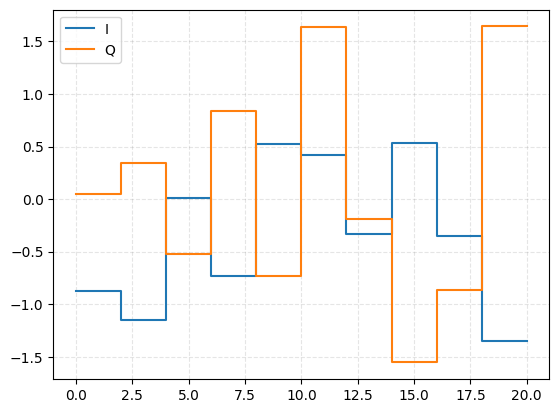

In [7]:
opt_result.plot()

In [8]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

In [9]:
sim_result.print_final_populations()

|0> : 33.33%
|1> : 33.33%
|2> : 33.33%


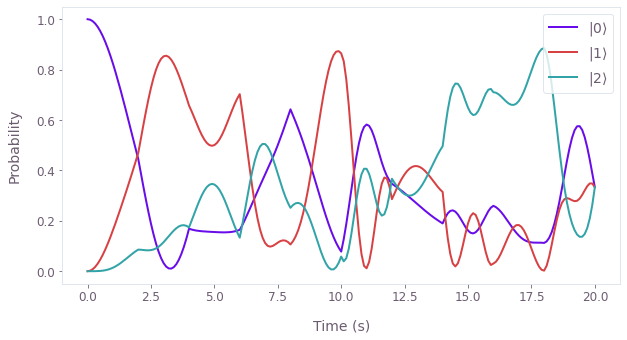

In [10]:
sim_result.plot_populations()

In [11]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>

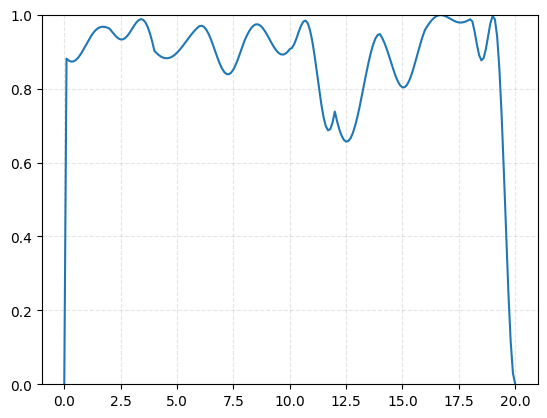

In [12]:
sim_result.plot_unitary_infidelities()

## Hadmard gate

In [13]:
optimizer = PulseOptimizer(
    dimension=2,
    detuning=0.0,
    anharmonicity=-0.3,
    segment_count=2,
    segment_width=2.0,
)

In [14]:
initial_params = optimizer.random_params()
initial_params

array([-0.26375228, -0.36227884, -0.82227551,  0.62580979])

In [15]:
w = np.exp(1j * 2 * np.pi / 3)

target_unitary = qt.Qobj(
    [
        [1, 1],
        [1, -1],
    ]
) / np.sqrt(2)
target_unitary

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

In [16]:
target_unitary.dag() * target_unitary

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [17]:
opt_result = optimizer.optimize(
    initial_params=initial_params,
    target_unitary=target_unitary,
)
opt_result

OptimizationResult(result=  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.297984273511247e-12
        x: [-1.247e-01  7.818e-01 -1.487e+00 -1.186e-01]
      nit: 8
      jac: [-2.682e-06  3.487e-06 -2.563e-06  7.451e-07]
 hess_inv: [[ 6.889e-01 -2.233e-02 -2.608e-01  1.668e-01]
            [-2.233e-02  5.638e-01 -6.975e-03 -2.429e-02]
            [-2.608e-01 -6.975e-03  5.461e-01  2.400e-02]
            [ 1.668e-01 -2.429e-02  2.400e-02  8.695e-01]]
     nfev: 65
     njev: 13, times=array([0., 2., 4.]), params=array([-0.12474862,  0.78179521, -1.48670959, -0.11861397]), pulse=array([-0.12474862+0.78179521j, -1.48670959-0.11861397j]))

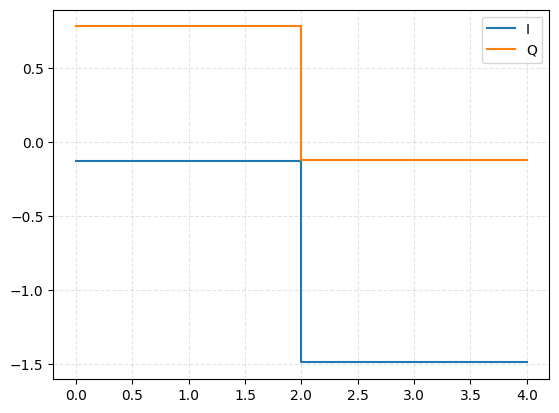

In [18]:
opt_result.plot()

In [19]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

In [20]:
sim_result.print_final_populations()

|0> : 50.00%
|1> : 50.00%


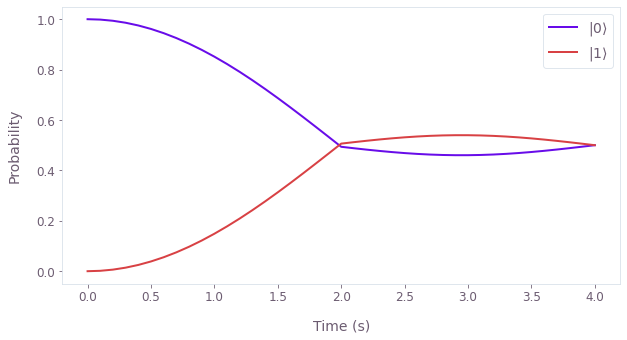

In [21]:
sim_result.plot_populations()

In [22]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>

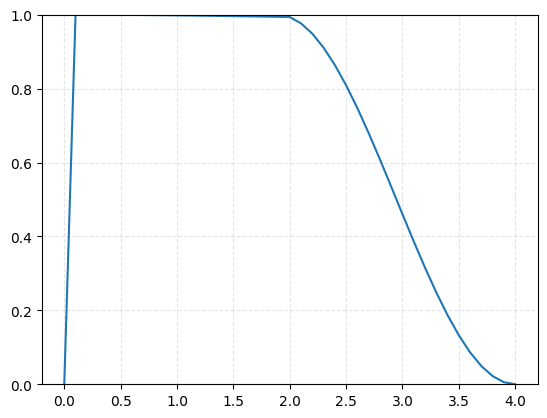

In [23]:
sim_result.plot_unitary_infidelities()